# Exploring the Grasp-and-List EEG Detection Dataset

A [Kaggle Challenge](https://www.kaggle.com/c/grasp-and-lift-eeg-detection) has provided us with ample of EEG data on subjects conducting certain trials. This notebook explores some this data in an effort to let us get to know it better.

Each subject performs the following events in one trial:

1. HandStart
2. FirstDigitTouch
3. BothStartLoadPhase
4. LiftOff
5. Replace
6. BothReleased

A video of the trial is shown:

In [5]:
YouTubeVideo('y3_Izuop2gY')

According to the [data specification page](https://www.kaggle.com/c/grasp-and-lift-eeg-detection/data), there are 12 subjects, 10 series of trials for each subject and 30 trials within each series. 

The data has been separated to put series 1-8 in the `training set` and the 9th and 10th series into the `test set` which will need to be predicted.

The `training set` also has events associated for each training entry, numbered from 1-6 according the above list. In the test set, these are not provided and we must build a model to predict which event occured within 150ms/ 75 frames. 

The researchers also provide a spatial relationship between the electrode locations which might be helpful at some point:

![https://kaggle2.blob.core.windows.net/competitions/kaggle/4477/media/EEG_Electrode_Numbering.jpg](https://kaggle2.blob.core.windows.net/competitions/kaggle/4477/media/EEG_Electrode_Numbering.jpg)

# Exploratory Data Analysis

Let's jump right in!

In [16]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [9]:
data = pd.read_csv('./data/train/subj10_series1_data.csv')

In [10]:
data.head()

,id,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,...,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
0,subj10_series1_0,-304,-156,-411,-640,-505,-603,-451,104,-344,...,-197,-597,-242,-472,-56,-338,-335,-518,-371,-177
1,subj10_series1_1,-300,-151,-376,-670,-509,-622,-422,60,-374,...,-203,-611,-224,-471,-53,-310,-326,-511,-396,-189
2,subj10_series1_2,-286,-227,-400,-724,-525,-631,-469,70,-378,...,-176,-608,-234,-475,-78,-282,-289,-505,-424,-193
3,subj10_series1_3,-281,-272,-447,-702,-540,-640,-492,71,-386,...,-154,-605,-246,-488,-73,-304,-337,-539,-412,-192
4,subj10_series1_4,-294,-194,-432,-693,-503,-609,-500,109,-385,...,-146,-602,-226,-448,-25,-342,-333,-549,-400,-157


33 columns is too many to plot, let us blindly select a few columns to plot.

ERROR! Session/line number was not unique in database. History logging moved to new session 1983


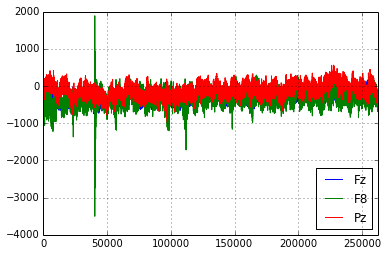

In [21]:
to_plot = data[['id', 'Fz', 'F8', 'Pz']]
to_plot.plot()

As we can see, the data is VERY noisy! We might need to extract only certain frequencies from this data using the Fast Fourier Transform.

Below let's see what's in the other `csv` file.

In [24]:
events = pd.read_csv('./data/train/subj10_series1_events.csv')
events.head()

,id,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
0,subj10_series1_0,0,0,0,0,0,0
1,subj10_series1_1,0,0,0,0,0,0
2,subj10_series1_2,0,0,0,0,0,0
3,subj10_series1_3,0,0,0,0,0,0
4,subj10_series1_4,0,0,0,0,0,0


In [56]:
events[events['FirstDigitTouch']>0].head()

,id,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
3732,subj10_series1_3732,0,1,0,0,0,0
3733,subj10_series1_3733,0,1,0,0,0,0
3734,subj10_series1_3734,0,1,1,0,0,0
3735,subj10_series1_3735,0,1,1,0,0,0
3736,subj10_series1_3736,0,1,1,0,0,0


It looks like it contains the events corresponding to the data in the previous file. Great.

## Convinience Functions and Processing

So we can see that the data is distributed among two files, [@alexandrebarachant](http://www.kaggle.com/alexandrebarachant) has created and posted from great starting scripts for us to use.

A python package called MNE will help us in our processing.